In [122]:
import cv2
import tensorflow as tf
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import imutils
import shutil
from tqdm import tqdm
from PIL import Image, ImageOps, ImageEnhance, ImageFilter


# Directories
obj_folder_path = r'D:\Daniel\PMD\YOLOv4_negatives\stroller data\stroller_pngs' # folder of object images dir
bg_images_path = r"D:\Daniel\PMD\YOLOv4_negatives\stroller data\TAV_backgrounds" # folder of background images dir
save_path = r"D:\Daniel\PMD\YOLOv4_negatives\stroller data\TAV_augmented_frames_2" # folder to save augmented backgrounds


In [352]:
###############################################
# Create all helper functions for augmentation #
################################################
'''
TEL-AVIV:
    Side View CCTV:
    CAM 1 view: y>= 600 | width, height = (75, 90)
    CAM 2 view: y>= 400 | width, height = (75, 90)

    Front-Back View CCTV
    CAM 3 view: x>= 900 , y<= 850   | width, height = (60, 100) if y>=500 | width, height = (40, 80) if 300<= y <500 | width, height = (30, 60) if y<300
    CAM 4 view: x<= 950    | width, height = (60, 100) if y>=500 | width, height = (40, 80) if 300<= y <500 | width, height = (30, 60) if y<300

'''
#ensures image format is PNG when running opencv operations
def png_format(img, pixel_threshold):

    if type(img) is str: #if image path
        filename = img.split('\\')[-1]
        if 'png' in filename: #if image is PNG
            img = cv2.imread(img, -1)  #imread_unchanged: read image and include alpha channel
            return img

        else:
            jpg_or = cv2.imread(img)


    else: # if image object (PIL format)
        img_array = np.array(img)

        if img_array.shape[2] == 4: # if image object is PNG
            return img_array
        
        else: #image object is RGB: 3 channels
            jpg_or = img_array
    
    z = np.ones(jpg_or.shape[:-1] + (1,), dtype=jpg_or.dtype)
    z = z*255
    jpg = np.concatenate((jpg_or, z), axis=-1)


    white_pixels = np.where(
        (jpg[:, :, 0] >= pixel_threshold) & 
        (jpg[:, :, 1] >= pixel_threshold) & 
        (jpg[:, :, 2] >= pixel_threshold))

    for x,y in zip(white_pixels[0],white_pixels[1]):
        jpg[x,y,3] = 0

    png = cv2.cvtColor(jpg, cv2.COLOR_BGR2BGRA)

    return png



# initialize smallest and largest object sizes and boundary coordinates given a background image
def initialize_sizes_and_coordinates(TAV_cam_view=None):
    if not TAV_cam_view: #i.e generic bg images
        nearest_obj = np.array([150 , 210]) #closest to cam
        furthest_obj = np.array([50, 80]) #furthest to cam     

        boundary_x, boundary_y = 0, 0
    
    elif 'cam1' in TAV_cam_view: #nearest: leftside, furthest: rightside
        nearest_obj = np.array([150 , 165]) #leftside
        furthest_obj = np.array([120 , 135]) #rightside

        boundary_x, boundary_y = 0, 400

    elif 'cam2' in TAV_cam_view:
        nearest_obj = np.array([120 , 135]) #leftside
        furthest_obj = np.array([80 , 95]) #rightside

        boundary_x, boundary_y = 0, 600

    elif 'cam3' in TAV_cam_view or 'cam4' in TAV_cam_view:
        nearest_obj = np.array([150 , 200]) #bottom
        furthest_obj = np.array([30, 60]) #top
    
        if 'cam3' in TAV_cam_view:
            boundary_x, boundary_y = 900, 850
        else:
            boundary_x, boundary_y = 950, 0

    return (nearest_obj, furthest_obj, boundary_x, boundary_y)



# returns random coordinates
def random_coords(frame_width, frame_height, boundary_x, boundary_y, TAV_cam_view=None):
    if not TAV_cam_view:
        x, y = random.randint(0, frame_width), random.randint(0, frame_height)
    elif 'cam1' in TAV_cam_view:
        x, y = random.randint(0, frame_width), random.randint(boundary_y, 800)
    elif 'cam2' in TAV_cam_view:
        x, y = random.randint(0, 1600), random.randint(boundary_y, 800)
    
    elif 'cam3' in TAV_cam_view:
        x, y = random.randint(boundary_x, frame_width), random.randint(0, boundary_y)
    
    elif 'cam4' in TAV_cam_view:
        x, y = random.randint(0, boundary_x), random.randint(0, frame_height)
    return (x, y)



# returns desired size of object given random coords
def desired_size(x,y, nearest_obj, furthest_obj, frame_width, frame_height, TAV_cam_view=None):
    if not TAV_cam_view:
        size = ((y/frame_height) * (nearest_obj- furthest_obj)) + furthest_obj
        size = tuple(map(int,size))
    elif 'cam1' in TAV_cam_view or 'cam2' in TAV_cam_view: #sideview
        size = ((x/frame_width) * (nearest_obj- furthest_obj)) + furthest_obj
        size = tuple(map(int,size))
    elif 'cam3' in TAV_cam_view or 'cam4' in TAV_cam_view: #front-back view
        size = ((y/frame_height) * (nearest_obj- furthest_obj)) + furthest_obj
        size = tuple(map(int,size))
    return size


# returns randomly augmented object image
def random_augment(image):
    yes_or_no = ['Yes', 'No']

    if random.choice(yes_or_no) == 'Yes':
        image = ImageOps.mirror(image) #flip horizontally

    if random.choice(yes_or_no) == 'Yes':
        brightness_factor = random.uniform(0.5,1.5) #adjust brightness
        image = ImageEnhance.Brightness(image).enhance(brightness_factor) 

    if random.choice(yes_or_no) == 'Yes':
        angle = random.randint(1, 20) #rotate image counter-clockwise
        if np.array(image).shape[2] == 3: #if image is JPEG, i.e 3 channels
            image = image.rotate(angle, Image.NEAREST, fillcolor='white')
        elif np.array(image).shape[2] == 4: #if image is PNG, i.e 4 channels
            image = image.rotate(angle, Image.NEAREST, expand=1)

    if random.choice(yes_or_no) == 'Yes':
        contrast_factor = random.uniform(0.5, 1.5) #adjust contrast
        image = ImageEnhance.Contrast(image).enhance(contrast_factor)

    if random.choice(yes_or_no) == 'Yes':
        image = image.filter(ImageFilter.BoxBlur(1)) #add box blurring, radius size = 1
    

    return image



# returns new resized image based on desired width: for cam1 and cam2
def image_resize_by_width(img, desired_width):
    orig_width, orig_height = img.size
    ratio = desired_width/orig_width

    new_size = (desired_width, int(orig_height*ratio))

    new_img = img.resize(new_size)
    return new_img



# returns new resized image based on desired height: for cam3 and cam4
def image_resize_by_height(img, desired_height):
    orig_width, orig_height = img.size
    ratio = desired_height/orig_height

    new_size = (int(orig_width*ratio), desired_height)

    new_img = img.resize(new_size)
    return new_img



# returns resized image based on cam_view
def image_resize(img, desired_size, TAV_cam_view=None):
    if not TAV_cam_view:
        return image_resize_by_height(img, desired_size[1])
    elif 'cam1' in TAV_cam_view or 'cam2' in TAV_cam_view:
        return image_resize_by_width(img, desired_size[0])
    
    elif 'cam3' in TAV_cam_view or 'cam4' in TAV_cam_view:
        return image_resize_by_height(img, desired_size[1])



# returns roi of background given object and random coords
def bg_roi_img(resized_obj_img, bg_img, random_x_coord, random_y_coord):

    # convert PIL format to array for opencv operations
    bg = np.array(bg_img)
    
    # dimesions of resized object image
    width, height = resized_obj_img.size

    # get desired coordinates of ROI in background image to place object
    desired_x_start = random_x_coord
    desired_y_start = random_y_coord
    desired_x_end = desired_x_start + width
    desired_y_end = desired_y_start + height
    
    # crop background image based on ROI coordinates
    roi = bg[desired_y_start:desired_y_end, desired_x_start:desired_x_end]
   
    #change width, height to height, width
    roi = cv2.resize(roi, (height, width))

    return roi #opencv format



# returns contour of object in image
def object_contour(obj_mask):
    # find all contours from object mask
    contours = cv2.findContours(obj_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # get largest contour: assuming it is the object
    contour = max(contours, key = cv2.contourArea)
    return contour



# returns width, height, top left and bottom right coordinates of object contour's bounding box
def bbox_coord(contour, random_x_coord, random_y_coord):
    c = contour

    extreme_Left = tuple(c[c[:, :, 0].argmin()][0])
    extreme_Right = tuple(c[c[:, :, 0].argmax()][0])
    extreme_Top = tuple(c[c[:, :, 1].argmin()][0])
    extreme_Bottom = tuple(c[c[:, :, 1].argmax()][0])

    # coordinates wrt to contour
    x_start = extreme_Left[0]
    y_start = extreme_Top[1]
    x_end = extreme_Right[0]
    y_end = extreme_Bottom[1]

    # width and height of bounding box
    bbox_width = x_end - x_start
    bbox_height = y_end - y_start

    #coordinates of bbox wrt to background image
    x_start = random_x_coord + x_start
    y_start = random_y_coord + y_start
    x_end = x_start + bbox_width
    y_end = y_start + bbox_height

    return(x_start, y_start, x_end, y_end, bbox_width, bbox_height)


# returns YOLO information
def get_yolo_information(obj_mask, random_x_coord, random_y_coord, frame_width, frame_height):
    # get contour of object
    height, width = obj_mask.shape[:2]
    obj_mask = cv2.resize(obj_mask, (height, width)) #resize mask to get correct bbox size
    contour = object_contour(obj_mask)

    # get dimensions and coordinates of object
    obj_x_start, obj_y_start, obj_x_end, obj_y_end, obj_width, obj_height = bbox_coord(contour, random_x_coord, random_y_coord)
    
    # center points of object
    center_x = (obj_x_start + obj_x_end)/2
    center_y = (obj_y_start + obj_y_end)/2

    # normalize coordinates
    normalized_center_x = center_x/frame_width
    normalized_center_y = center_y/frame_height

    normalized_obj_width = obj_width/frame_width
    normalized_obj_height = obj_height/frame_height

    return [normalized_center_x, normalized_center_y, normalized_obj_width, normalized_obj_height]


# returns object mask and inverted mask
def obj_mask_and_inverted_mask(resized_img):
    # dimesions of resized object given random coords
    width, height = resized_img.size

    # read image using opencv to perform bitwise operations
    object = png_format(resized_img, 200)
    object = cv2.resize(object, (height, width))

    # create object mask and inverted mask
    obj_mask = object[:,:,3]
    obj_mask_inverted = cv2.bitwise_not(obj_mask) #returns one’s complement of the number


    return (obj_mask, obj_mask_inverted) #opencv format



# returns object background and foreground images given object mask and inverted mask
def object_foreground_and_background(obj_mask, obj_mask_inverted, roi, resized_object_img):
    # dimesions of resized object given random coords
    width, height = resized_object_img.size

    # read image and convert to BGR for opencv operations
    object = png_format(resized_object_img, 200)
    object = cv2.resize(object, (height, width))
    object = cv2.cvtColor(object, cv2.COLOR_RGB2BGR)
    
    # get bg and fg images
    bg = cv2.bitwise_and(roi, roi, mask = obj_mask_inverted)
    fg = cv2.bitwise_and(object, object, mask = obj_mask)

    # convert foreground to RGB
    fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)

    return(bg, fg) #opencv format



# returns object img with selected background
def img_with_mask(obj_path, desired_obj_size, bg_img, random_x_coord, random_y_coord, frame_width, frame_height, TAV_cam_view = None):
    
    # resize object image based on desired size
    object_img = Image.open(obj_path)
    resized_object_img = image_resize(object_img, desired_obj_size, TAV_cam_view)
    
    # randomly augment resized object
    resized_object_img = random_augment(resized_object_img)
    
    # get ROI of background image
    bg_roi = bg_roi_img(resized_object_img, bg_img, random_x_coord, random_y_coord)
    
    # get object mask and inverted mask
    obj_mask, obj_mask_inverted = obj_mask_and_inverted_mask(resized_object_img)
     
    # get YOLO information
    yolo_info = get_yolo_information(obj_mask, random_x_coord, random_y_coord, frame_width, frame_height)

    # get object background and foreground images
    obj_bg, obj_fg = object_foreground_and_background(obj_mask, obj_mask_inverted, bg_roi, resized_object_img)

    # combine obj bg and fg images together
    img_with_mask = cv2.add(obj_bg, obj_fg)
    img_with_mask = Image.fromarray(np.uint8(img_with_mask))
    img_with_mask = img_with_mask.resize(resized_object_img.size) #opencv height/width to PIL height/width

    return (img_with_mask, yolo_info)



# overlays object on background
def overlay_img_on_bg(img_with_mask, bg_img, random_coords):
    bg_img.paste(img_with_mask, random_coords)
    return bg_img



# converts RGBA PNG to RGB
def format_rgb(image):
    background = Image.new('RGB', image.size, (255, 255, 255))
    background.paste(image, mask = image.split()[3])
    return background



# creates text file for each background image
def create_yolo_txt_file(yolo_lst, save_bg_file_name, YOLO_txt = False):
    save = save_bg_file_name + '.txt'
    if YOLO_txt:
        with open(save, "w") as txt_object:
            for yolo_info in yolo_lst:
                for i in range(len(yolo_info)):
                    txt_object.write(str(yolo_info[i]))
                    if i < len(yolo_info)-1:
                        txt_object.write(' ')
                
                txt_object.write('\n')
    


# returns augmented background image with specified number of objects 
def augmented_bg_with_objects(bg_path, num_of_objects, object_folder_path, YOLO_CLASSID = None):
    
    # create YOLO list for YOLO text file
    YOLO_lst = []
    if YOLO_CLASSID is not None:
        CLASSID = YOLO_CLASSID
    else:
        CLASSID = 'no_class_id_given'
    
    # get list of object image paths
    lst_object_paths = os.listdir(object_folder_path)

    # randomly sample object images in the list
    if num_of_objects>len(lst_object_paths):
        num_of_objects = 1
        print('Number of objects exceeded available quantity, defaulting to 1 object')
    sampled_object_paths = random.sample(lst_object_paths, num_of_objects)

    # get filename of background
    bg_name = bg_path.split('\\')[-1]
    if 'cam' in bg_name:
        TAV_cam_view = bg_name
    else:
        TAV_cam_view = None
    
    # initialize smallest and largest object sizes and boundary coordinates
    nearest_obj, furthest_obj, boundary_x, boundary_y = initialize_sizes_and_coordinates(TAV_cam_view)

    # background image dimension
    bg_img = Image.open(bg_path).convert('RGB')
    frame_width, frame_height = bg_img.size

    for obj_path in sampled_object_paths:
        # full path of object image
        obj_path = object_folder_path + '\\' + obj_path

        # random coords
        random_x_coord, random_y_coord = random_coords(frame_width, frame_height, boundary_x, boundary_y, TAV_cam_view)
        random_coordinates = (random_x_coord, random_y_coord)

        # desired size of object given random coords
        size = desired_size(random_x_coord, random_y_coord, nearest_obj, furthest_obj, frame_width, frame_height, TAV_cam_view)

        # obtain image with mask
        img_mask, yolo_info = img_with_mask(obj_path, size, bg_img, random_x_coord, random_y_coord, frame_width, frame_height, TAV_cam_view)
        
        # overlay object on background
        bg_img = overlay_img_on_bg(img_mask, bg_img, random_coordinates)

        # insert CLASSID into yolo_info list
        yolo_info.insert(0, CLASSID)
        YOLO_lst.append(yolo_info)
    
    #convert to RGB format
    # try:
    #     bg_img = format_rgb(bg_img)
    # except:
    #     pass
    
    return bg_img, YOLO_lst
    


# generate augmented backgrounds with objects
def generate_augmented_backgrounds(num_of_augmented_frames, num_of_objects, obj_folder_path, bg_images_path, save_path, YOLO_txt = False, YOLO_CLASSID = None):
    # num_of_augmented_frames: specify number of frames to be augmented
    # num_of_objects: specified number of objects if <10, else, randomly generate number of objects to put inside each bg image
    # obj_folder_path: path for folder of objects
    # bg_images_path: path for folder of backgrounds
    # save_path: path to save augmented images
    # YOLO_txt: True if generating yolo text files, else False
    # YOLO_CLASSID: specify CLASSID
    
    # randomize the number of objects
    if num_of_objects >= 10:
        num_of_objects = random.randint(10,15)
    elif num_of_objects >=5 and num_of_objects <10:
        num_of_objects = random.randint(5, 9)


    for i in tqdm(range(num_of_augmented_frames)):
        # get list of background image paths
        lst_bg_paths = os.listdir(bg_images_path)

        # randomly sample background image in the list
        bg_name = random.choice(lst_bg_paths)
        bg_path = bg_images_path + '\\' + bg_name
        bg_name = bg_name.split('.')[0]

        # complete path to save background image
        save_bg_name = save_path + '\\' + f'{bg_name}_{i}'

        #NOTE: there are occasions where random coordinates generated contain a 0, thus we avoid an error by implementing Try/Except
        try: 
            # get augmented background and YOLO list
            bg_img, YOLO_lst = augmented_bg_with_objects(bg_path, num_of_objects, obj_folder_path, YOLO_CLASSID)

            # save augmented background (and YOLO txt file if activated)
            bg_img.save(save_bg_name + '.jpg')
            create_yolo_txt_file(YOLO_lst, save_bg_name, YOLO_txt)
        except Exception as e:
            print(e)
            pass
            


In [290]:
######################################
# Execute: Generate augmented frames #
######################################
# 1st input: number of frames to augment
# 2nd input: number of objects in each frame
# 3rd input: object path
# 4th input: background images path
# 5th input: save path
# 6th input: YOLO_txt = True if generating YOLO text files
# 7th input: YOLO_CLASSID = integer

# WITH YOLO TXT FILES
# generate_augmented_backgrounds(5, 4, obj_folder_path, bg_images_path, save_path, YOLO_txt= True, YOLO_CLASSID=0)

# WITHOUT YOLO TXT FILES
generate_augmented_backgrounds(1, 5, obj_folder_path, bg_images_path, save_path)


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


57 5 168 196
111


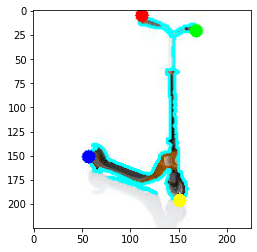

In [38]:
#########################################
# Getting coordinates of object contour #
#########################################

imgpath = r"D:\Daniel\PMD\YOLOv4_negatives\scooters\16.jpg"

image = cv2.imread(imgpath)

img = Image.open(imgpath)
obj_mask, obj_mask_inverted = obj_mask_and_inverted_mask(imgpath, img)

contours = cv2.findContours(obj_mask.copy(), cv2. RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

# get largest contour
c = max(contours, key = cv2.contourArea)

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

print(extLeft[0], extTop[1], extRight[0], extBot[1]) #bbox coords
print(extRight[0]-extLeft[0]) #object width

cv2.drawContours(image, [c], -1, (0, 255, 255), 2)
cv2.circle(image, extLeft, 7, (0, 0, 255), -1)
cv2.circle(image, extRight, 7, (0, 255, 0), -1)
cv2.circle(image, extTop, 7, (255, 0, 0), -1)
cv2.circle(image, extBot, 7, (255, 255, 0), -1)

# show the output image
plt.imshow(image)


In [353]:
# Directories
obj_folder_path = r"D:\Daniel\PMD\YOLOv4_negatives\boxes\boxes_object" # folder of object images dir
bg_images_path = r"D:\Daniel\PMD\YOLOv4_negatives\stroller data\TAV_backgrounds" # folder of background images dir
save_path = r"D:\Daniel\PMD\YOLOv4_negatives\boxes\augmented_frames" # folder to save augmented backgrounds

generate_augmented_backgrounds(5,4,obj_folder_path, bg_images_path, save_path, YOLO_txt=True, YOLO_CLASSID=0)


100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


In [316]:
##########
# Backup #
##########

###############################################
# Create all helper functions for augmentation #
################################################
'''
TEL-AVIV:
    Side View CCTV:
    CAM 1 view: y>= 600 | width, height = (75, 90)
    CAM 2 view: y>= 400 | width, height = (75, 90)

    Front-Back View CCTV
    CAM 3 view: x>= 900 , y<= 850   | width, height = (60, 100) if y>=500 | width, height = (40, 80) if 300<= y <500 | width, height = (30, 60) if y<300
    CAM 4 view: x<= 950    | width, height = (60, 100) if y>=500 | width, height = (40, 80) if 300<= y <500 | width, height = (30, 60) if y<300

'''
#ensures image format is PNG when running opencv operations
def png_format(img, pixel_threshold):

    if type(img) is str: #if image path
        filename = img.split('\\')[-1]
        if 'png' in filename: #if image is PNG
            img = cv2.imread(img, -1)  #imread_unchanged: read image and include alpha channel
            return img

        else:
            jpg_or = cv2.imread(img)


    else: # if image object (PIL format)
        img_array = np.array(img)

        if img_array.shape[2] == 4: # if image object is PNG
            return img_array
        
        else: #image object is RGB: 3 channels
            jpg_or = img_array
    
    z = np.ones(jpg_or.shape[:-1] + (1,), dtype=jpg_or.dtype)
    z = z*255
    jpg = np.concatenate((jpg_or, z), axis=-1)


    white_pixels = np.where(
        (jpg[:, :, 0] >= pixel_threshold) & 
        (jpg[:, :, 1] >= pixel_threshold) & 
        (jpg[:, :, 2] >= pixel_threshold))

    for x,y in zip(white_pixels[0],white_pixels[1]):
        jpg[x,y,3] = 0

    png = cv2.cvtColor(jpg, cv2.COLOR_BGR2BGRA)

    return png



# initialize smallest and largest object sizes and boundary coordinates given a background image
def initialize_sizes_and_coordinates(TAV_cam_view=None):
    if not TAV_cam_view: #i.e generic bg images
        nearest_obj = np.array([150 , 210]) #closest to cam
        furthest_obj = np.array([50, 80]) #furthest to cam     

        boundary_x, boundary_y = 0, 0
    
    elif 'cam1' in TAV_cam_view: #nearest: leftside, furthest: rightside
        nearest_obj = np.array([150 , 165]) #leftside
        furthest_obj = np.array([120 , 135]) #rightside

        boundary_x, boundary_y = 0, 400

    elif 'cam2' in TAV_cam_view:
        nearest_obj = np.array([120 , 135]) #leftside
        furthest_obj = np.array([80 , 95]) #rightside

        boundary_x, boundary_y = 0, 600

    elif 'cam3' in TAV_cam_view or 'cam4' in TAV_cam_view:
        nearest_obj = np.array([150 , 200]) #bottom
        furthest_obj = np.array([30, 60]) #top
    
        if 'cam3' in TAV_cam_view:
            boundary_x, boundary_y = 900, 850
        else:
            boundary_x, boundary_y = 950, 0

    return (nearest_obj, furthest_obj, boundary_x, boundary_y)



# returns random coordinates
def random_coords(frame_width, frame_height, boundary_x, boundary_y, TAV_cam_view=None):
    if not TAV_cam_view:
        x, y = random.randint(0, frame_width), random.randint(0, frame_height)
    elif 'cam1' in TAV_cam_view:
        x, y = random.randint(0, frame_width), random.randint(boundary_y, 800)
    elif 'cam2' in TAV_cam_view:
        x, y = random.randint(0, 1600), random.randint(boundary_y, 800)
    
    elif 'cam3' in TAV_cam_view:
        x, y = random.randint(boundary_x, frame_width), random.randint(0, boundary_y)
    
    elif 'cam4' in TAV_cam_view:
        x, y = random.randint(0, boundary_x), random.randint(0, frame_height)
    return (x, y)



# returns desired size of object given random coords
def desired_size(x,y, nearest_obj, furthest_obj, frame_width, frame_height, TAV_cam_view=None):
    if not TAV_cam_view:
        size = ((y/frame_height) * (nearest_obj- furthest_obj)) + furthest_obj
        size = tuple(map(int,size))
    elif 'cam1' in TAV_cam_view or 'cam2' in TAV_cam_view: #sideview
        size = ((x/frame_width) * (nearest_obj- furthest_obj)) + furthest_obj
        size = tuple(map(int,size))
    elif 'cam3' in TAV_cam_view or 'cam4' in TAV_cam_view: #front-back view
        size = ((y/frame_height) * (nearest_obj- furthest_obj)) + furthest_obj
        size = tuple(map(int,size))
    return size


# returns randomly augmented object image
def random_augment(image):
    yes_or_no = ['Yes', 'No']

    if random.choice(yes_or_no) == 'Yes':
        image = ImageOps.mirror(image) #flip horizontally

    if random.choice(yes_or_no) == 'Yes':
        brightness_factor = random.uniform(0.5,1.5) #adjust brightness
        image = ImageEnhance.Brightness(image).enhance(brightness_factor) 

    if random.choice(yes_or_no) == 'Yes':
        angle = random.randint(1, 20) #rotate image counter-clockwise
        if np.array(image).shape[2] == 3: #if image is JPEG, i.e 3 channels
            image = image.rotate(angle, Image.NEAREST, fillcolor='white')
        elif np.array(image).shape[2] == 4: #if image is PNG, i.e 4 channels
            image = image.rotate(angle, Image.NEAREST, expand=1)

    if random.choice(yes_or_no) == 'Yes':
        contrast_factor = random.uniform(0.5, 1.5) #adjust contrast
        image = ImageEnhance.Contrast(image).enhance(contrast_factor)

    if random.choice(yes_or_no) == 'Yes':
        image = image.filter(ImageFilter.BoxBlur(1)) #add box blurring, radius size = 1
    

    return image



# returns new resized image based on desired width: for cam1 and cam2
def image_resize_by_width(img, desired_width):
    orig_width, orig_height = img.size
    ratio = desired_width/orig_width

    new_size = (desired_width, int(orig_height*ratio))

    new_img = img.resize(new_size)
    return new_img



# returns new resized image based on desired height: for cam3 and cam4
def image_resize_by_height(img, desired_height):
    orig_width, orig_height = img.size
    ratio = desired_height/orig_height

    new_size = (int(orig_width*ratio), desired_height)

    new_img = img.resize(new_size)
    return new_img



# returns resized image based on cam_view
def image_resize(img, desired_size, TAV_cam_view=None):
    if not TAV_cam_view:
        return image_resize_by_height(img, desired_size[1])
    elif 'cam1' in TAV_cam_view or 'cam2' in TAV_cam_view:
        return image_resize_by_width(img, desired_size[0])
    
    elif 'cam3' in TAV_cam_view or 'cam4' in TAV_cam_view:
        return image_resize_by_height(img, desired_size[1])



# returns roi of background given object and random coords
def bg_roi_img(resized_obj_img, bg_img, random_x_coord, random_y_coord):

    # convert PIL format to array for opencv operations
    bg = np.array(bg_img)
    
    # dimesions of resized object image
    width, height = resized_obj_img.size

    # get desired coordinates of ROI in background image to place object
    desired_x_start = random_x_coord
    desired_y_start = random_y_coord
    desired_x_end = desired_x_start + width
    desired_y_end = desired_y_start + height
    
    # crop background image based on ROI coordinates
    roi = bg[desired_y_start:desired_y_end, desired_x_start:desired_x_end]
   
    #change width, height to height, width
    roi = cv2.resize(roi, (height, width))

    return roi #opencv format



# returns contour of object in image
def object_contour(obj_mask):
    # find all contours from object mask
    contours = cv2.findContours(obj_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # get largest contour: assuming it is the object
    contour = max(contours, key = cv2.contourArea)
    return contour



# returns width, height, top left and bottom right coordinates of object contour's bounding box
def bbox_coord(contour, random_x_coord, random_y_coord):
    c = contour

    extreme_Left = tuple(c[c[:, :, 0].argmin()][0])
    extreme_Right = tuple(c[c[:, :, 0].argmax()][0])
    extreme_Top = tuple(c[c[:, :, 1].argmin()][0])
    extreme_Bottom = tuple(c[c[:, :, 1].argmax()][0])

    # coordinates wrt to contour
    x_start = extreme_Left[0]
    y_start = extreme_Top[1]
    x_end = extreme_Right[0]
    y_end = extreme_Bottom[1]

    # width and height of bounding box
    bbox_width = x_end - x_start
    bbox_height = y_end - y_start

    #coordinates of bbox wrt to background image
    x_start = random_x_coord + x_start
    y_start = random_y_coord + y_start
    x_end = x_start + bbox_width
    y_end = y_start + bbox_height

    return(x_start, y_start, x_end, y_end, bbox_width, bbox_height)


# returns YOLO information
def get_yolo_information(obj_mask, random_x_coord, random_y_coord, frame_width, frame_height):
    # get contour of object
    height, width = obj_mask.shape[:2]
    obj_mask = cv2.resize(obj_mask, (height, width)) #resize mask to get correct bbox size
    contour = object_contour(obj_mask)

    # get dimensions and coordinates of object
    obj_x_start, obj_y_start, obj_x_end, obj_y_end, obj_width, obj_height = bbox_coord(contour, random_x_coord, random_y_coord)
    
    # center points of object
    center_x = (obj_x_start + obj_x_end)/2
    center_y = (obj_y_start + obj_y_end)/2

    # normalize coordinates
    normalized_center_x = center_x/frame_width
    normalized_center_y = center_y/frame_height

    normalized_obj_width = obj_width/frame_width
    normalized_obj_height = obj_height/frame_height

    return [normalized_center_x, normalized_center_y, normalized_obj_width, normalized_obj_height]


# returns object mask and inverted mask
def obj_mask_and_inverted_mask(resized_img):
    # dimesions of resized object given random coords
    width, height = resized_img.size

    # read image using opencv to perform bitwise operations
    object = png_format(resized_img, 200)
    object = cv2.resize(object, (height, width))

    # create object mask and inverted mask
    obj_mask = object[:,:,3]
    obj_mask_inverted = cv2.bitwise_not(obj_mask) #returns one’s complement of the number


    return (obj_mask, obj_mask_inverted) #opencv format



# returns object background and foreground images given object mask and inverted mask
def object_foreground_and_background(obj_mask, obj_mask_inverted, roi, resized_object_img):
    # dimesions of resized object given random coords
    width, height = resized_object_img.size

    # read image and convert to BGR for opencv operations
    object = png_format(resized_object_img, 200)
    object = cv2.resize(object, (height, width))
    object = cv2.cvtColor(object, cv2.COLOR_RGB2BGR)
    
    # get bg and fg images
    bg = cv2.bitwise_and(roi, roi, mask = obj_mask_inverted)
    fg = cv2.bitwise_and(object, object, mask = obj_mask)

    # convert foreground to RGB
    fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
    
    return(bg, fg) #opencv format



# returns object img with selected background
def img_with_mask(obj_path, desired_obj_size, bg_img, random_x_coord, random_y_coord, frame_width, frame_height, TAV_cam_view = None):
    
    # resize object image based on desired size
    object_img = Image.open(obj_path)
    resized_object_img = image_resize(object_img, desired_obj_size, TAV_cam_view)
    
    # randomly augment resized object
    resized_object_img = random_augment(resized_object_img)
    
    # get ROI of background image
    bg_roi = bg_roi_img(resized_object_img, bg_img, random_x_coord, random_y_coord)
    
    # get object mask and inverted mask
    obj_mask, obj_mask_inverted = obj_mask_and_inverted_mask(resized_object_img)
     
    # get YOLO information
    yolo_info = get_yolo_information(obj_mask, random_x_coord, random_y_coord, frame_width, frame_height)

    # get object background and foreground images
    obj_bg, obj_fg = object_foreground_and_background(obj_mask, obj_mask_inverted, bg_roi, resized_object_img)

    # combine obj bg and fg images together
    img_with_mask = cv2.add(obj_bg, obj_fg)
    img_with_mask = Image.fromarray(np.uint8(img_with_mask))
    img_with_mask = img_with_mask.resize(resized_object_img.size) #opencv height/width to PIL height/width

    return (img_with_mask, yolo_info)



# overlays object on background
def overlay_img_on_bg(img_with_mask, bg_img, random_coords):
    bg_img.paste(img_with_mask, random_coords)
    return bg_img



# converts RGBA PNG to RGB
def format_rgb(image):
    background = Image.new('RGB', image.size, (255, 255, 255))
    background.paste(image, mask = image.split()[3])
    return background



# creates text file for each background image
def create_yolo_txt_file(yolo_lst, save_bg_file_name, YOLO_txt = False):
    save = save_bg_file_name + '.txt'
    if YOLO_txt:
        with open(save, "w") as txt_object:
            for yolo_info in yolo_lst:
                for i in range(len(yolo_info)):
                    txt_object.write(str(yolo_info[i]))
                    if i < len(yolo_info)-1:
                        txt_object.write(' ')
                
                txt_object.write('\n')
    


# returns augmented background image with specified number of objects 
def augmented_bg_with_objects(bg_path, num_of_objects, object_folder_path, YOLO_CLASSID = None):
    
    # create YOLO list for YOLO text file
    YOLO_lst = []
    if YOLO_CLASSID is not None:
        CLASSID = YOLO_CLASSID
    else:
        CLASSID = 'no_class_id_given'
    
    # get list of object image paths
    lst_object_paths = os.listdir(object_folder_path)

    # randomly sample object images in the list
    if num_of_objects>len(lst_object_paths):
        num_of_objects = 1
        print('Number of objects exceeded available quantity, defaulting to 1 object')
    sampled_object_paths = random.sample(lst_object_paths, num_of_objects)

    # get filename of background
    bg_name = bg_path.split('\\')[-1]
    if 'cam' in bg_name:
        TAV_cam_view = bg_name
    else:
        TAV_cam_view = None
    
    # initialize smallest and largest object sizes and boundary coordinates
    nearest_obj, furthest_obj, boundary_x, boundary_y = initialize_sizes_and_coordinates(TAV_cam_view)

    # background image dimension
    bg_img = Image.open(bg_path).convert('RGB')
    frame_width, frame_height = bg_img.size

    for obj_path in sampled_object_paths:
        # full path of object image
        obj_path = object_folder_path + '\\' + obj_path

        # random coords
        random_x_coord, random_y_coord = random_coords(frame_width, frame_height, boundary_x, boundary_y, TAV_cam_view)
        random_coordinates = (random_x_coord, random_y_coord)

        # desired size of object given random coords
        size = desired_size(random_x_coord, random_y_coord, nearest_obj, furthest_obj, frame_width, frame_height, TAV_cam_view)

        # obtain image with mask
        img_mask, yolo_info = img_with_mask(obj_path, size, bg_img, random_x_coord, random_y_coord, frame_width, frame_height, TAV_cam_view)
        
        # overlay object on background
        bg_img = overlay_img_on_bg(img_mask, bg_img, random_coordinates)

        # insert CLASSID into yolo_info list
        yolo_info.insert(0, CLASSID)
        YOLO_lst.append(yolo_info)
    
    #convert to RGB format
    # try:
    #     bg_img = format_rgb(bg_img)
    # except:
    #     pass
    
    return bg_img, YOLO_lst
    


# generate augmented backgrounds with objects
def generate_augmented_backgrounds(num_of_augmented_frames, num_of_objects, obj_folder_path, bg_images_path, save_path, YOLO_txt = False, YOLO_CLASSID = None):
    # num_of_augmented_frames: specify number of frames to be augmented
    # num_of_objects: specified number of objects if <10, else, randomly generate number of objects to put inside each bg image
    # obj_folder_path: path for folder of objects
    # bg_images_path: path for folder of backgrounds
    # save_path: path to save augmented images
    # YOLO_txt: True if generating yolo text files, else False
    # YOLO_CLASSID: specify CLASSID
    
    # randomize the number of objects
    if num_of_objects >= 10:
        num_of_objects = random.randint(10,15)
    elif num_of_objects >=5 and num_of_objects <10:
        num_of_objects = random.randint(5, 9)


    for i in tqdm(range(num_of_augmented_frames)):
        # get list of background image paths
        lst_bg_paths = os.listdir(bg_images_path)

        # randomly sample background image in the list
        bg_name = random.choice(lst_bg_paths)
        bg_path = bg_images_path + '\\' + bg_name
        bg_name = bg_name.split('.')[0]

        # complete path to save background image
        save_bg_name = save_path + '\\' + f'{bg_name}_{i}'

        #NOTE: there are occasions where random coordinates generated contain a 0, thus we avoid an error by implementing Try/Except
        try: 
            # get augmented background and YOLO list
            bg_img, YOLO_lst = augmented_bg_with_objects(bg_path, num_of_objects, obj_folder_path, YOLO_CLASSID)

            # save augmented background (and YOLO txt file if activated)
            bg_img.save(save_bg_name + '.jpg')
            create_yolo_txt_file(YOLO_lst, save_bg_name, YOLO_txt)
        except Exception as e:
            print(e)
            pass



######################################
# Execute: Generate augmented frames #
######################################
# 1st input: number of frames to augment
# 2nd input: number of objects in each frame

# WITH YOLO TXT FILES
# generate_augmented_backgrounds(5, 4, obj_folder_path, bg_images_path, save_path, YOLO_txt= True, YOLO_CLASSID=0)

# WITHOUT YOLO TXT FILES
generate_augmented_backgrounds(5, 4, obj_folder_path, bg_images_path, save_path)


100%|██████████| 5/5 [00:00<00:00, 13.67it/s]
